# Structured data classification II

*This tutorial is mainly based on the Keras tutorial ["Structured data classification from scratch"](https://keras.io/examples/structured_data/structured_data_classification_from_scratch/) by François Chollet and ["Classify structured data using Keras preprocessing layers"](https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers) by TensorFlow.*

- This tutorial demonstrates how to do structured binary classification with Keras, starting from a raw CSV file. 

- This example is an advanced version of [](structured_data_classification_intro.ipynb) since we will use more functions and less code.

## Setup

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers

tf.__version__

'2.7.1'

## Data

- We use the features below to predict whether a patient has a heart disease (`Target`).

Column| Description| Feature Type
------------|--------------------|----------------------
Age | Age in years | Numerical
Sex | (1 = male; 0 = female) | Categorical
CP | Chest pain type (0, 1, 2, 3, 4) | Categorical
Trestbpd | Resting blood pressure (in mm Hg on admission) | Numerical
Chol | Serum cholesterol in mg/dl | Numerical
FBS | fasting blood sugar in 120 mg/dl (1 = true; 0 = false) | Categorical
RestECG | Resting electrocardiogram results (0, 1, 2) | Categorical
Thalach | Maximum heart rate achieved | Numerical
Exang | Exercise induced angina (1 = yes; 0 = no) | Categorical
Oldpeak | ST depression induced by exercise relative to rest | Numerical
Slope | Slope of the peak exercise ST segment | Numerical
CA | Number of major vessels (0-3) colored by fluoroscopy | Both numerical & categorical
Thal | normal; fixed defect; reversible defect | Categorical (string)
Target | Diagnosis of heart disease (1 = true; 0 = false) | Target

### Data import


- Let's download the data and load it into a Pandas dataframe:

In [2]:
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
df = pd.read_csv(file_url)

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB


### Define label

- Define outcome variable as `y_label`

In [4]:
y_label = 'target'

### Data format

First, we make some changes to our data

- Due to computational performance reasons we change:
 
  - `int64` to `int32`
  - `float64` to `float32` 

In [5]:
# Make a dictionary with int64 columns as keys and np.int32 as values
int_32 = dict.fromkeys(df.select_dtypes(np.int64).columns, np.int32)
# Change all columns from dictionary
df = df.astype(int_32)

# Make a dictionary with float64 columns as keys and np.float32 as values
float_32 = dict.fromkeys(df.select_dtypes(np.float64).columns, np.float32)
df = df.astype(float_32)

In [6]:
int_32

{'age': numpy.int32,
 'sex': numpy.int32,
 'cp': numpy.int32,
 'trestbps': numpy.int32,
 'chol': numpy.int32,
 'fbs': numpy.int32,
 'restecg': numpy.int32,
 'thalach': numpy.int32,
 'exang': numpy.int32,
 'slope': numpy.int32,
 'ca': numpy.int32,
 'target': numpy.int32}

- Next, we take care of our categorical data:

In [7]:
# Convert to string
df['thal'] = df['thal'].astype("string")

In [8]:
# Convert to categorical

# make a list of all categorical variables
cat_convert = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'ca']

# convert variables
for i in cat_convert:
    df[i] = df[i].astype("category")

- Finally, we make lists of feature variables for later data preprocessing steps 
- Since we don't want to include our label in our data preprocessing steps, we make sure to exclude it

In [9]:
# Make list of all numerical data (except label)
list_num = df.drop(columns=[y_label]).select_dtypes(include=[np.number]).columns.tolist()

# Make list of all categorical data which is stored as integers (except label)
list_cat_int = df.drop(columns=[y_label]).select_dtypes(include=['category']).columns.tolist()

# Make list of all categorical data which is stored as string (except label)
list_cat_string = df.drop(columns=[y_label]).select_dtypes(include=['string']).columns.tolist()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       303 non-null    int32   
 1   sex       303 non-null    category
 2   cp        303 non-null    category
 3   trestbps  303 non-null    int32   
 4   chol      303 non-null    int32   
 5   fbs       303 non-null    category
 6   restecg   303 non-null    category
 7   thalach   303 non-null    int32   
 8   exang     303 non-null    category
 9   oldpeak   303 non-null    float32 
 10  slope     303 non-null    int32   
 11  ca        303 non-null    category
 12  thal      303 non-null    string  
 13  target    303 non-null    int32   
dtypes: category(6), float32(1), int32(6), string(1)
memory usage: 13.5 KB


### Data splitting

- Let's split the data into a training and validation set

In [11]:
# Make validation data
df_val = df.sample(frac=0.2, random_state=1337)

# Create training data
df_train = df.drop(df_val.index)

In [12]:
print(
    "Using %d samples for training and %d for validation"
    % (len(df_train), len(df_val))
)

Using 242 samples for training and 61 for validation


### Transform to Tensors

- Let's generate [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) objects for our training and validation dataframes

- The following utility function converts each training and validation set into a tf.data.Dataset, then shuffles and batches the data.

In [13]:
# Define a function to create our tensors

def dataframe_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop(y_label)
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    df = ds.prefetch(batch_size)
    return ds

- Next, we test our function

In [16]:
batch_size = 32

ds_train = dataframe_to_dataset(df_train, shuffle=True, batch_size=batch_size)
ds_val = dataframe_to_dataset(df_val, shuffle=True, batch_size=batch_size)

## Feature preprocessing

- Next, we define utility functions to do the feature preprocessing operations.

- In this tutorial, you will use the following preprocessing layers to demonstrate how to perform preprocessing, structured data encoding, and feature engineering:

- `tf.keras.layers.Normalization`: Performs feature-wise normalization of input features.

- `tf.keras.layers.CategoryEncoding`: Turns integer categorical features into one-hot, multi-hot, or tf-idf dense representations.

- `tf.keras.layers.StringLookup`: Turns string categorical values into integer indices.

- `tf.keras.layers.IntegerLookup`: Turns integer categorical values into integer indices.


### Numerical preprocessing function

- Define a new utility function that returns a layer which applies feature-wise normalization to numerical features using that Keras preprocessing layer:

In [18]:
# Define numerical preprocessing function
def get_normalization_layer(name, dataset):
    
    # Create a Normalization layer for our feature
    normalizer = layers.Normalization(axis=None)

    # Prepare a dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    return normalizer

- Next, test the new function by calling it on the total uploaded pet photo features to normalize 'PhotoAmt':

In [19]:
test_age_feature = train_features['age']

test_age_layer = get_normalization_layer('age', train_ds)

test_age_layer(test_age_feature)

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 0.60617566,  1.2847923 ,  1.5109979 , -0.6379548 , -0.07244093],
      dtype=float32)>

### Categorical preprocessing functions

- Define another new utility function that returns a layer which maps values from a vocabulary to integer indices and multi-hot encodes the features using the tf.keras.layers.StringLookup, tf.keras.layers.IntegerLookup, and tf.keras.CategoryEncoding preprocessing layers:

In [20]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

- Test the get_category_encoding_layer function by calling it on pet 'Thal' features to turn them into multi-hot encoded tensors:

In [21]:
test_thal_feature = train_features['thal']

test_thal_layer = get_category_encoding_layer(name='thal',
                                              dataset=train_ds,
                                              dtype='string')
test_thal_layer(test_thal_feature)

<tf.Tensor: shape=(6,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 0.], dtype=float32)>

### Data preprocessing

Next, we will:

- Apply the preprocessing utility functions defined earlier on our numerical and categorical features and store it into `encoded_features`
- Add all the feature inputs to a list called `all_inputs`.

In [22]:
all_inputs = []
encoded_features = []

#### Create tensors 

- Earlier, we used a small batch size to demonstrate the input pipeline. 
- Let's now create a new input pipeline with a larger batch size of 256:

#### Numerical preprocessing

- Normalize the numerical features 
- Add them to one list of inputs called `encoded_features`:

In [23]:
# Numerical features.
for feature in list_num:
  numeric_col = tf.keras.Input(shape=(1,), name=feature)
  normalization_layer = get_normalization_layer(feature, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

#### Categorical preprocessing

- Turn the integer categorical values from the dataset into integer indices, perform multi-hot encoding and add the resulting feature inputs to encoded_feature

In [24]:
for feature in list_cat_int:
  categorical_col = tf.keras.Input(shape=(1,), name=feature, dtype='int32')
  encoding_layer = get_category_encoding_layer(name=feature,
                                               dataset=train_ds,
                                               dtype='int32',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

In [25]:
for feature in list_cat_string:
  categorical_col = tf.keras.Input(shape=(1,), name=feature, dtype='string')
  encoding_layer = get_category_encoding_layer(name=feature,
                                               dataset=train_ds,
                                               dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

- Merge the list of feature inputs (encoded_features) into one vector via concatenation with layers.concatenate.

In [26]:
all_features = layers.concatenate(encoded_features)

## Model

Now we can build the model using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional): 

1. We use 32 number of units in the first layer
1. We use [layers.Dropout()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) to prevent overvitting
1. Our output layer has 1 output (since the classification task is binary)
1. tf.keras.Model groups layers into an object with training and inference features.


In [27]:
# First layer
x = layers.Dense(32, activation="relu")(all_features)
# Dropout to prevent overvitting
x = layers.Dropout(0.2)(x)
# Output layer
output = layers.Dense(1, activation="sigmoid")(x)

# Group all layers 
model = tf.keras.Model(all_inputs, output)

- Configure the model with Keras Model.compile:

In [28]:
model.compile(optimizer="adam", 
              loss ="binary_crossentropy", 
              metrics=["accuracy"])

Let's visualize our connectivity graph:

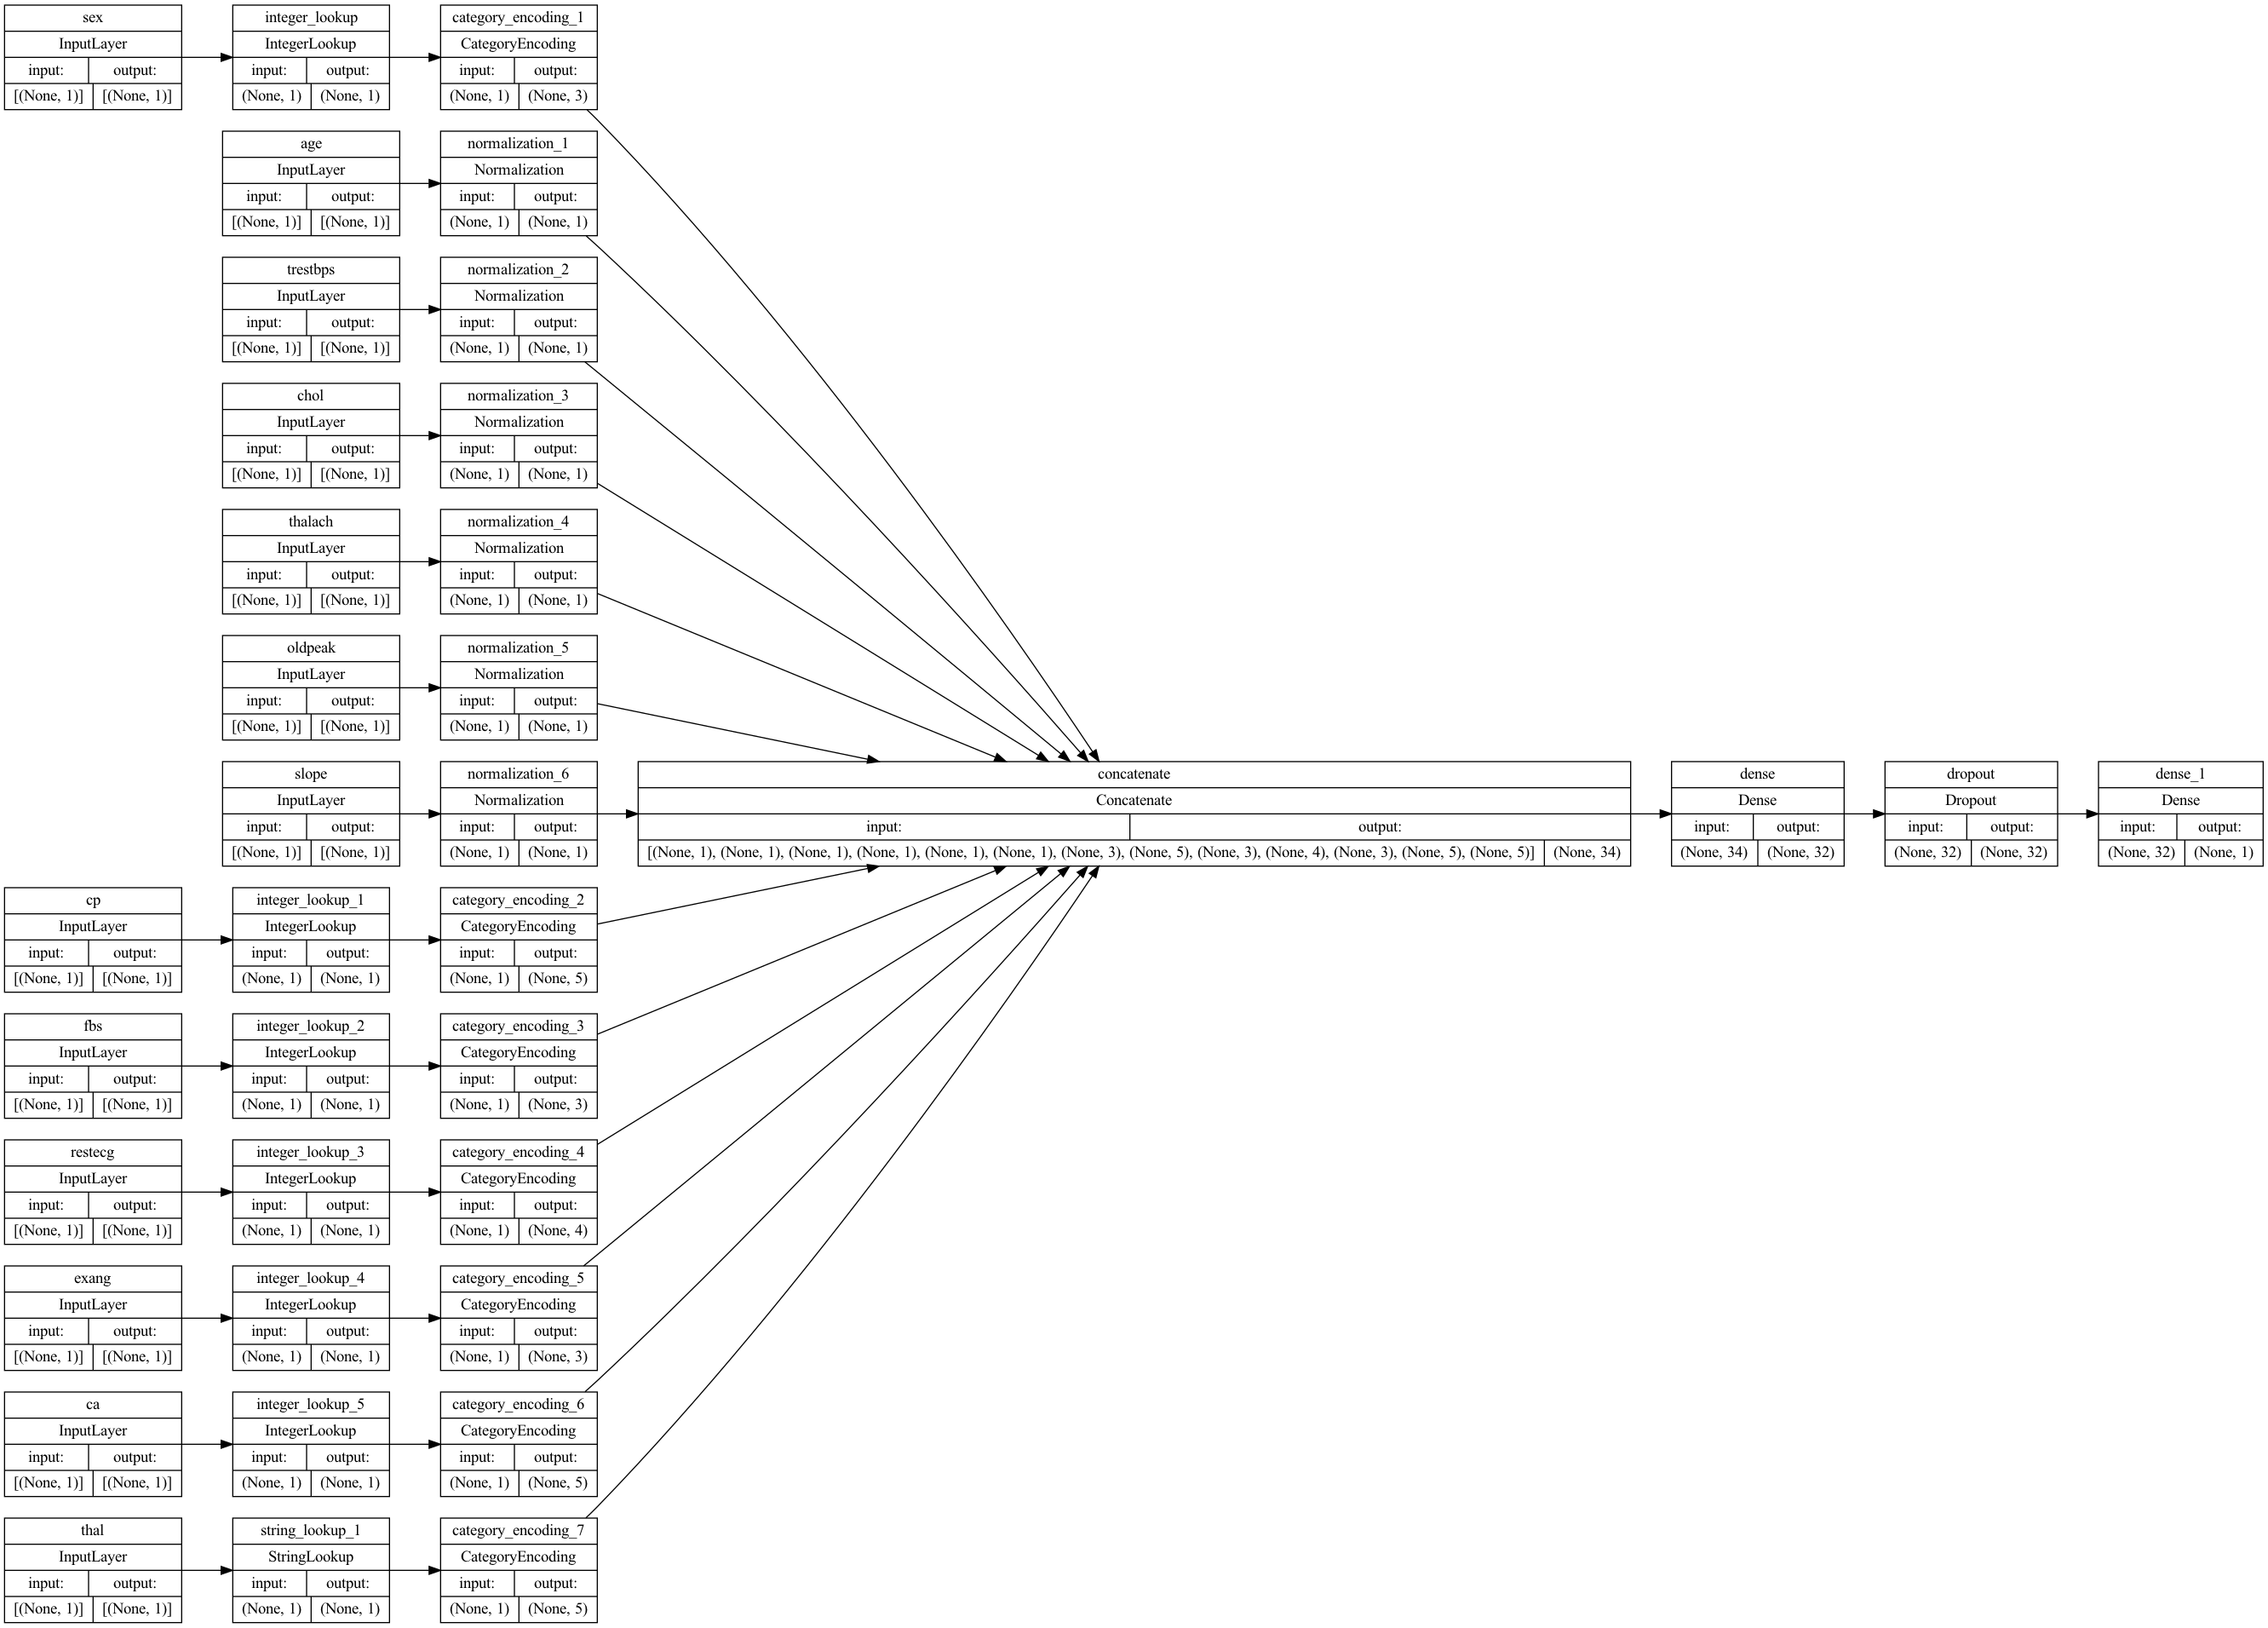

In [29]:
# `rankdir='LR'` is to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

## Training

- Next, train and test the model:

In [30]:
model.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
8/8 [==============================] - 1s 46ms/step - loss: 0.7813 - accuracy: 0.4669 - val_loss: 0.7286 - val_accuracy: 0.5082
Epoch 2/10
8/8 [==============================] - 0s 3ms/step - loss: 0.7046 - accuracy: 0.5620 - val_loss: 0.6505 - val_accuracy: 0.6885
Epoch 3/10
8/8 [==============================] - 0s 3ms/step - loss: 0.6218 - accuracy: 0.7025 - val_loss: 0.5874 - val_accuracy: 0.7377
Epoch 4/10
8/8 [==============================] - 0s 3ms/step - loss: 0.5833 - accuracy: 0.7314 - val_loss: 0.5383 - val_accuracy: 0.8033
Epoch 5/10
8/8 [==============================] - 0s 3ms/step - loss: 0.5335 - accuracy: 0.7934 - val_loss: 0.5010 - val_accuracy: 0.8361
Epoch 6/10
8/8 [==============================] - 0s 4ms/step - loss: 0.5048 - accuracy: 0.7727 - val_loss: 0.4729 - val_accuracy: 0.8689
Epoch 7/10
8/8 [==============================] - 0s 3ms/step - loss: 0.4825 - accuracy: 0.8099 - val_loss: 0.4515 - val_accuracy: 0.8525
Epoch 8/10
8/8 [=================

In [31]:
loss, accuracy = model.evaluate(ds_val)

print("Accuracy", accuracy)

2/2 [==============================] - 0s 2ms/step - loss: 0.4087 - accuracy: 0.8197
Accuracy 0.8196721076965332


## Perform inference

- The model you have developed can now classify a row from a CSV file directly after you've included the preprocessing layers inside the model itself. Let's demonstrate the process:

- Save the heart diseases classification model

In [32]:
model.save('my_hd_classifier')

2022-04-28 18:26:00.165539: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: my_hd_classifier/assets


- Load model

In [33]:
reloaded_model = tf.keras.models.load_model('my_hd_classifier')

- To get a prediction for a new sample, you can simply call the Keras Model.predict method.
- There are just two things you need to do:

  - Wrap scalars into a list so as to have a batch dimension (Models only process batches of data, not single samples).
  - Call tf.convert_to_tensor on each feature.

In [34]:
sample = {
    "age": 60,
    "sex": 1,
    "cp": 1,
    "trestbps": 145,
    "chol": 233,
    "fbs": 1,
    "restecg": 2,
    "thalach": 150,
    "exang": 0,
    "oldpeak": 2.3,
    "slope": 3,
    "ca": 0,
    "thal": "fixed",
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}

predictions = reloaded_model.predict(input_dict)

print(
    "This particular patient had a %.1f percent probability "
    "of having a heart disease, as evaluated by our model." % (100 * predictions[0][0],)
)

This particular patient had a 45.2 percent probability of having a heart disease, as evaluated by our model.


## Next steps

The tutorial [](keras-imdb.ipynb) covers how to build a binary sentiment classification model with keras using keras layers for data preprocessing and TensorBoard to view model results.

To learn more about classifying structured data, try working with other datasets. Below are some suggestions for datasets:

- [TensorFlow Datasets: MovieLens](https://www.tensorflow.org/datasets/catalog/movie_lens): A set of movie ratings from a movie recommendation service.

- [TensorFlow Datasets: Wine Quality](https://www.tensorflow.org/datasets/catalog/wine_quality): Two datasets related to red and white variants of the Portuguese "Vinho Verde" wine. You can also find the Red Wine Quality dataset on Kaggle.

- [Kaggle: arXiv Dataset](https://www.kaggle.com/Cornell-University/arxiv): A corpus of 1.7 million scholarly articles from arXiv, covering physics, computer science, math, statistics, electrical engineering, quantitative biology, and economics.